# Two Layer NN Digit Classifier Using MNIST 

MNIST is a dataset of low res images of hand written digits.
In this notebook I will explore the math and implement from scratch in python different nueral network structures and compare their performance.
 
Data Structure and Notation:
* 28 x 28 pixel images, 784 pixels
* $m$ training images
* $X$ is a matrix with dimensions $m$ by 784 
    * $X^{T}$ is used for input into nueral network model

 ## Basic NN Structure
input layer: 784 nodes  
* 28 by 28 images flattened into a vector  

hidden layer: h nodes (h in image below) 
* This parameter should be optimized based on performace. 

output layer: 10 nodes (o in images below)
* 10 classes or digits, so 10 nodes 

Note: In images below true matrix size is not shown. Dimensions are noted by variables next to each axis.

## Forward Propagation
Forward propagation is the process of transforming our input data into our output data.   
Forward propagation for our two layer neural network is imaged below.  

![forward_prop](../data/imgs/2layer_forward_prop.svg)

The input layer is simply a matrix of our raw training data.  
Input Layer Definition:
* $A^{[0]} = X\space\space\text{with dimensions } 784\space \text{x} \space m$

The hidden layer values are obtained by a linear transformation of the input layer followed by a non-linear transformation or activation of the transformed input data.  
We are using the rectified linear unit or ReLU as the activation function for our hidden layer. 

$\text{RelU}(x) = \{x \hspace{0.5em} \text{if} \hspace{0.5em} x > 0, \hspace{1em} 0 \hspace{0.5em} \text{if} \hspace{0.5em} \le 0\}$ 

Hidden Layer Definition:
* $Z^{[1]} = w^{[1]} \cdot A^{[0]} + b^{[1]}$ (Unactivated: linear transformation of input layer)
* $A^{[1]} = g(Z^{[1]}) = \text{ReLu}(Z^{[1]})$ (Activated: ReLU transformation of linear transformation)

The output layer works similarly to the hidden layer but with an output specific activation function. \
The hidden layer is linearally transformed and this time we use a softmax as an activation function to convert our transformed values into probabilities.   
The softmax essentially calculates the contribution of each not to the total output vector.

$\text{softmax}(x) = \dfrac{e^{x_{i}}}{\sum_{i=1}^{k} e^{x_{i}}}$

* $Z^{[2]} = w^{[2]} \cdot A^{[2]} + b^{[2]}$ (Unactivated: linear tranformation of hidden layer)
* $A^{[2]} = \text{softmax}(Z^{[2]})$ (Activated: probabilities of input being a given class)

## Back Propagation
Back Propagation is the process we use to learn the weights and biases in the forward propagation process.  
It works by finding the error in the weights, biases, and predictions working backward from the output layer. 
This process for our two layer neural network is imaged below.  

![back_prop](../data/imgs/2layer_back_prop.svg)

First step is to find the error of the output layer by subtracting the classes from our output layer matrix.  
Y is the digit pictured in each image in the training set. Y is a one-hot encoded 10 by m matrix. 

* $dZ^{[2]} = A^{[2]} - Y$ (error of predictions)

The next step is to find the error associated with weights and biases used in the linear transformation in the second layer.

* $dw^{[2]} = \frac{1}{m} dZ^{[2]} \cdot A^{[1]T}$ (contributions of layer 2 weights to prediction error)
* $db^{[2]} = \frac{1}{m} \sum dZ^{[2]}$ (contributions of layer 2 biases to prediction error)

Repeat this process to find error of weights and biases in the first layer. Must undo activation function. 
$g`$ is the derivative of the activation function
* $dZ^{[1]} = w^{[2]T} dZ^{[2]} \cdot g`(Z^{[1]})$ (error of Hidden Layer transformation)
* $dw^{[1]} = \frac{1}{m} dZ^{[1]} X^T$ (contribution of weights to layer 2 error)
* $db^{[1]} = \frac{1}{m} \sum dZ^{[1]}$ (contribution of biases to layer 2 error)

## Weight and Bias Update
Weights and biases are then updated after calculating their errors in backpropagation. \
The new values are generated by subtracting the error multiplied by a learning rate parameter. \
The learning rate $\alpha$ is a user defined constant that modifies how much the weights and biases are changed in each cycle

* $w^{[1_{}]}_{new} = w^{[1]} - \alpha dw^{[1]}$
* $b^{[1]}_{new} = b^{[1]} - \alpha db^{[1]}$
* $w^{[2]}_{new} = w^{[2]} - \alpha dw^{[1]}$
* $b^{[2]}_{new} = b^{[2]} - \alpha db^{[2]}$

This process of using forward propagation to make predictions follow by backward propagation to find the error and "learn" new weights \
is repeats till our predictions reach reach some sort of convergence. This training process in known as gradient descent. 





### Neural Network Code ###
Below I've programmed some functions and classes to make a two layer neural network from scratch. \
I've chosen to make general classes for a layer and a Two Layer nn so I can easily change the size of the layers and other parameters for optimization.  


In [1]:
import sys
import os
import struct
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt

### ACTIVATION FUNCTIONS ####
def ReLU(vec: np.array):
    return np.maximum(vec, 0)

def deriv_ReLU(vec: np.array):
    return vec > 0

def softmax(vec: np.array):
    exp = np.exp(vec - np.max(vec))
    probs = exp / exp.sum(axis = 0)
    return probs

#### LOSS FUNCTIONS ####

def mse(pred:np.array, one_hot_labels: np.array):
    return np.mean((pred - one_hot_labels) ** 2)

def mae(pred:np.array, one_hot_labels: np.array):
    return np.mean(np.abs(pred - one_hot_labels))

#### Utility Functions ####
def get_predictions(nn_out):
    return np.argmax(nn_out, 0)

def get_accuracy(pred, labels):
    return np.sum(pred == labels) / labels.size

def one_hot(vec: np.array):
    one_hot_vec = np.zeros((vec.size, vec.max() + 1))
    one_hot_vec[np.arange(vec.size), vec] = 1
    return one_hot_vec.T


##### NN CLASSES #######

class Layer(object):


    def __init__(self, layer_id, input_size, node_count, activation_func):

        # Layer metadata
        self.layer_id = layer_id
        self.node_count = node_count
        self.activation_func = activation_func
        # random init of weights and biases
        self.weights = np.random.rand(node_count, input_size) - 0.5
        self.biases = np.random.rand(node_count, 1) - 0.5
    
    def transform(self, input_dat: np.array):

        lin_transform = self.weights.dot(input_dat) + self.biases
        self.unactivated_node_values = lin_transform
        node_values = self.activation_func(lin_transform) 
        self.node_values = node_values

        return node_values

    def update_weights_n_biases(self, weight_error, bias_error, learning_rate):

        self.weights -= learning_rate * weight_error
        self.biases -= learning_rate * bias_error.reshape(self.node_count, 1)


class TwoLayerNN(object):


    def __init__(
            self,
            train_dat: np.array,
            train_labels: np.array,
            test_dat: np.array,
            test_labels: np.array,
            hidden_nodes: int,
            output_nodes: int,
            learning_rate: float,
        ):

        self.train_dat = train_dat / 255 # divide to make values between 0 and 1
        self.train_labels = train_labels
        self.one_hot_train_labels = one_hot(train_labels)
        self.test_dat = test_dat / 255 # divide to make values between 0 and 1
        self.test_labels = test_labels
        self.one_hot_test_labels = one_hot(test_labels)
        self.learning_rate = learning_rate
        self.hidden_layer = Layer("hidden", train_dat.shape[0], hidden_nodes, activation_func = ReLU)
        self.output_layer = Layer("out", hidden_nodes, output_nodes, activation_func = softmax)

    def forward_prop(self, dataset = "train"):

        if dataset == "train":
            data = self.train_dat
        elif dataset == "test":
            data = self.test_dat

        hidden_transformed = self.hidden_layer.transform(data)
        out = self.output_layer.transform(hidden_transformed)

        return out

    def backward_prop(self, out):

        m = self.train_dat.shape[1]
        # prediction error
        dZ_o = out - self.one_hot_train_labels
        dw_o = (1 / m) * dZ_o.dot(self.hidden_layer.node_values.T) 
        db_o =  (1 / m) * np.sum(dZ_o, 1)
        # hidden layer error
        dZ_h =  self.output_layer.weights.T.dot(dZ_o) * deriv_ReLU(self.hidden_layer.unactivated_node_values)
        dw_h = (1 / m) * dZ_h.dot(self.train_dat.T)
        db_h =  (1 / m) * np.sum(dZ_h, 1)
        # update weights and biases from error components
        self.hidden_layer.update_weights_n_biases(dw_h, db_h, self.learning_rate)
        self.output_layer.update_weights_n_biases(dw_o, db_o, self.learning_rate)

    def gradient_descent(self, iterations):

        print(f"Running model with {self.hidden_layer.node_count} hidden layer nodes")

        for i in range(iterations):
            pred = self.forward_prop(dataset = "train")
            self.backward_prop(pred)
            if (i + 1) % 1000 == 0:
                dig_pred = get_predictions(pred)
                acc = get_accuracy(dig_pred, self.train_labels)
                print(f"training accuracy @ iter {i+1} = {acc}")
    
    def test_accuracy(self):

        pred = self.forward_prop(dataset = "test")
        dig_pred = get_predictions(pred)
        acc = get_accuracy(dig_pred, self.test_labels)
        print(f"Testing accuracy = {acc}")

        return acc



### Loading the Data Visualizing an Image
In the code below I'm loading in the data and formatting to instantiate my nueral network. 

2049 60000
2051 60000 28 28
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   3.  18.
  18.  18. 126. 136. 175.  26. 166. 255. 247. 127.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.  30.  36.  94. 154. 170. 253.
 253. 253. 253. 253. 225. 172. 253. 242. 195.  64

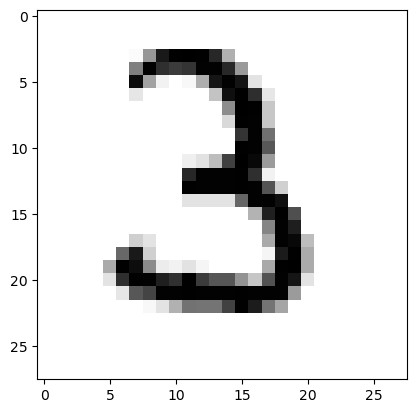

In [5]:
datpath = "../../data/mnist"

def read_mnist(im_path, label_path):

    # open training binary training data 
    with open(label_path, mode = "rb") as f:
        # first 8 bytes hold label metadata
        magic, items, = struct.unpack(">II", f.read(8)) 
        print(magic, items)
        buf = f.read()
        labels = np.frombuffer(buf, dtype = np.uint8)
        f.close()
    
    with open(im_path, mode = "rb") as f:
        # first 16 bytes hold image metadata
        magic, items, dim1, dim2 = struct.unpack(">IIII", f.read(16)) 
        print(magic, items, dim1, dim2)
        buf = f.read()
        imgs = np.frombuffer(buf, dtype = np.uint8).astype(np.float32)
        # reshape data into matrix of flattened images
        imgs = imgs.reshape(items, dim1 * dim2)
        f.close()

    return imgs, labels 


# read in training 
train_dat, train_labels = read_mnist(f"{datpath}/train-images.idx3-ubyte", f"{datpath}/train-labels.idx1-ubyte")
test_dat, test_labels = read_mnist(f"{datpath}/t10k-images.idx3-ubyte", f"{datpath}/t10k-labels.idx1-ubyte")

# show example of image in dataset
# data is in flattened vector format, must be reshaped to 2d image to be viewed
im_num = 546 
image = train_dat[im_num, :].reshape(28, 28)
print(train_labels[im_num])
plt.imshow(image, cmap = plt.cm.gray_r)

### Training the Neural Network
Below I train the two layer neural network with a 1 hidden layer with 10 nodes, a learning rate of 0.1 and 1000 training iterations.  
This initial model ends up with testing and training accuracy around mid 80%.

In [41]:
# init NN object
nn = TwoLayerNN(train_dat.T, train_labels, test_dat.T, test_labels, hidden_nodes = 10, output_nodes = 10, learning_rate = 0.10)
nn.gradient_descent(iterations = 1000)
nn.test_accuracy()

iter: 100 accuracy = 0.5579166666666666
iter: 200 accuracy = 0.6876
iter: 300 accuracy = 0.74285
iter: 400 accuracy = 0.7777
iter: 500 accuracy = 0.8039166666666666
iter: 600 accuracy = 0.8230666666666666
iter: 700 accuracy = 0.8373333333333334
iter: 800 accuracy = 0.8479
iter: 900 accuracy = 0.8557833333333333
iter: 1000 accuracy = 0.8629833333333333
Testing accuracy = 0.8638


### Hidden Layer Node Count Optimization
Below I will attempt to optimize the two layer neural network with the following constraints.
* learning rate = 0.1
* only optimizing the number of nodes in the hidden layer 
* only using 100 nodes maximun to save training time

In [38]:
#set random state for cross model comparison
np.random.RandomState(seed = 7734)

min_nodes = 10
max_nodes = 100

def split(min_n, max_n):
    return int((min_n + max_n) / 2)

def run_model(node_count):

    nodes = split(min_nodes, max_nodes)
    nn = TwoLayerNN(train_dat.T, train_labels, test_dat.T, test_labels, hidden_nodes = node_count, output_nodes = 10, learning_rate = 0.10)
    nn.gradient_descent(iterations = 1000)
    acc = nn.test_accuracy()

    return acc, nn

min_acc, min_mod = run_model(min_nodes)
max_acc, max_mod = run_model(max_nodes)

dif = max_nodes - min_nodes

while dif > 5:

    nodes = split(min_nodes, max_nodes)
    dif = max_nodes - min_nodes
    acc, mod = run_model(nodes)

    if min_acc > acc and acc > max_acc:
        max_nodes = nodes
        max_acc = acc
        max_mod = mod
        best = min_mod

    elif max_acc > acc and acc > min_acc:

        min_nodes = nodes
        min_acc = acc
        min_mod = mod
        best = max_mod
    
    elif acc > max_acc and acc > min_acc:

        if max_acc > min_acc:
            min_nodes = nodes
            min_acc = acc
            min_mod = mod
            best = mod

        elif min_acc > max_acc:
            max_nodes = nodes
            max_acc = acc
            max_mod = mod
            best = mod
    print(f"best model: {best.hidden_layer.node_count} nodes ")
    best_acc = best.test_accuracy()

Running model with 10 hidden layer nodes
training accuracy @ iter 1000 = 0.8772333333333333
Testing accuracy = 0.8813
Running model with 100 hidden layer nodes
training accuracy @ iter 1000 = 0.9278
Testing accuracy = 0.9267
Running model with 55 hidden layer nodes
training accuracy @ iter 1000 = 0.9131333333333334
Testing accuracy = 0.9141
best model: 100 nodes 
Testing accuracy = 0.9267
Running model with 77 hidden layer nodes
training accuracy @ iter 1000 = 0.9190166666666667
Testing accuracy = 0.9171
best model: 100 nodes 
Testing accuracy = 0.9267
Running model with 88 hidden layer nodes
training accuracy @ iter 1000 = 0.9188333333333333
Testing accuracy = 0.92
best model: 100 nodes 
Testing accuracy = 0.9267
Running model with 94 hidden layer nodes
training accuracy @ iter 1000 = 0.9245333333333333
Testing accuracy = 0.92
best model: 100 nodes 
Testing accuracy = 0.9267
Running model with 94 hidden layer nodes
training accuracy @ iter 1000 = 0.92155
Testing accuracy = 0.9154
best

### Hidden Layer Optimization Results

I applied a binary search method to find the best number of nodes between 10 and 100 nodes.   
The best model had 100 nodes in the hidden layer. The trend in the data above suggests that more nodes in the hidden layer leads to better predictons. This makes sense as more nodes means more parameters learned within the model allowing for more flexibility. It is very likely a model with more layers and nodes would result in better performance. However further optimization of the hidden layer in this model is out of scope